In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    primeira = 1
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        print(f"Tempo: {t}")
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        if isinstance(t, float):
             rho_vector[0][int(round(t,0))+r] = pt[0][0]
             rho_vector[1][int(round(t,0))+r] = pt[0][1]
             rho_vector[2][int(round(t,0))+r] = pt[1][0]
             rho_vector[3][int(round(t,0))+r] = pt[1][1]
             r += 1
        else:
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        # if 1/2*(1+rt[2][0]) > 0.9995:
        #     distance_vector.pop()
        #     fx_vector.pop()
        #     fy_vector.pop()
        #     fz_vector.pop()
        #     fid_vector.pop()
        #     fid_autores.pop()
        #     resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        #     u[0] = resultado_algoritmo_genetico[0]
        #     u[1] = resultado_algoritmo_genetico[1]
        #     u[2] = resultado_algoritmo_genetico[2]
        while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
            print(f"Processo de infactibilidade")
            print(f"Porta: {fid_autores[-1]}")
            print(f"Estados: {fid_vector[-1]}")
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            aas[-1] = ((u[0],u[1],u[2]))
        
        if t <= 70:
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
        elif t > 70:
            h = 0.001
            if primeira:
                while D > 5*10**(-3):
                    resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
                    u[0] = resultado_algoritmo_genetico[0]
                    u[1] = resultado_algoritmo_genetico[1]
                    u[2] = resultado_algoritmo_genetico[2]
                    a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
                    rt = np.dot(Uto, r0)
                    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
                    fid_v = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
                    fid_a = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
                    distancia = np.linalg.norm(Uto-Uf)**2
                    if 1/2*(1+rt[2][0]) > 1 or fid_a > 1 or fid_v > 1:
                        print(f"Repetindo, houve infactibilidade.")
                    else:
                        fid_vector[-1] = fid_v
                        fid_autores[-1] = fid_a
                        aaas = ((u[0],u[1],u[2]))
                        D = distancia
                        Ut = Uto
                        t += 1
                t = 71
                t += 1
                primeira = 0
            else:
                print(f"Alcançou-se um valor desejável")
                resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
                u[0] = resultado_algoritmo_genetico[0]
                u[1] = resultado_algoritmo_genetico[1]
                u[2] = resultado_algoritmo_genetico[2]
                t += 1
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Tempo: 0
Tempo: 1
Tempo: 2
Tempo: 3
Tempo: 4
Tempo: 5
Tempo: 6
Tempo: 7
Tempo: 8
Tempo: 9
Tempo: 10
Tempo: 11
Tempo: 12
Tempo: 13
Tempo: 14
Tempo: 15
Tempo: 16
Tempo: 17
Tempo: 18
Tempo: 19
Tempo: 20
Tempo: 21
Tempo: 22
Tempo: 23
Tempo: 24
Tempo: 25
Tempo: 26
Tempo: 27
Tempo: 28
Tempo: 29
Tempo: 30
Tempo: 31
Tempo: 32
Tempo: 33
Tempo: 34
Tempo: 35
Tempo: 36
Tempo: 37
Tempo: 38
Tempo: 39
Tempo: 40
Tempo: 41
Tempo: 42
Tempo: 43
Tempo: 44
Tempo: 45
Tempo: 46
Tempo: 47
Tempo: 48
Tempo: 49
Tempo: 50
Tempo: 51
Tempo: 52
Tempo: 53
Tempo: 54
Tempo: 55
Tempo: 56
Tempo: 57
Tempo: 58
Tempo: 59
Tempo: 60
Tempo: 61
Tempo: 62
Tempo: 63
Tempo: 64
Tempo: 65
Tempo: 66
Tempo: 67
Tempo: 68
Tempo: 69
Tempo: 70
Tempo: 71
Tempo: 72
Alcançou-se um valor desejável
Tempo: 73
Alcançou-se um valor desejável
Tempo: 74
Alcançou-se um valor desejável
Tempo: 75
Alcançou-se um valor desejável
Tempo: 76
Alcançou-se um valor desejável
Tempo: 77
Alcançou-se um valor desejável
Tempo: 78
Alcanç

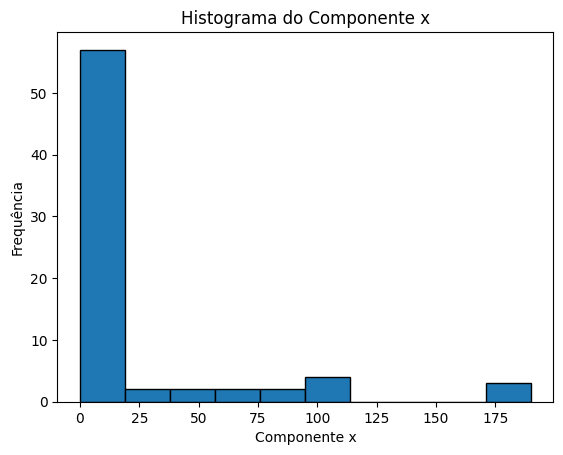

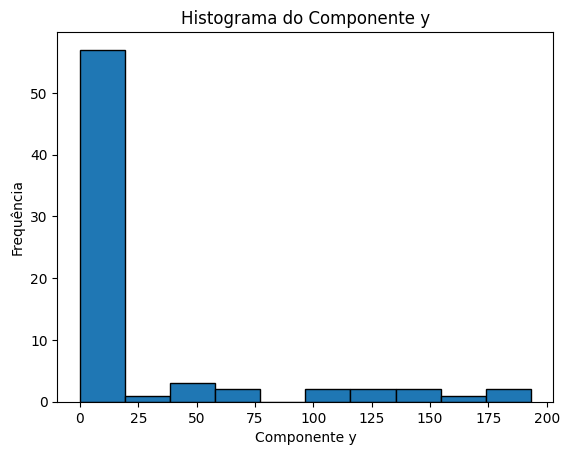

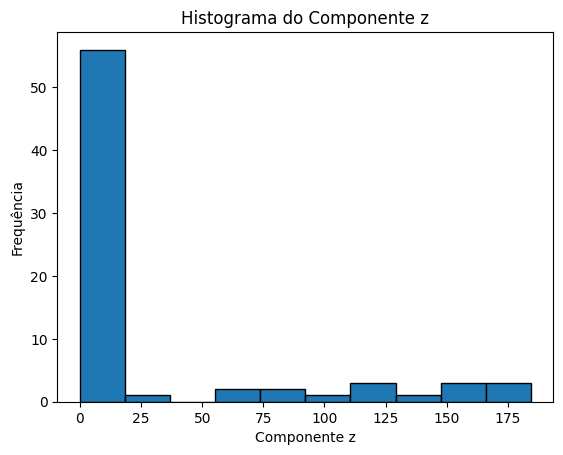

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.99830462235102
Estados: (0.9994879965952872-8.468160776147987e-22j)
Distância: 7.452776345692177e-05
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[np.clongdouble('0.5000429273004758005+4.371492615006879097e-05j'),
 np.clongdouble('0.53109475151692269915-3.6265543615568187175e-12j'),
 np.clongdouble('0.56220898459887777224+7.9046456906052055265e-06j'),
 np.clongdouble('0.56217720553879597364-5.982618333949987019e-05j'),
 np.clongdouble('0.56206433467817842203-2.94503173273841602e-05j'),
 np.clongdouble('0.5618473694628680319+0.00028551495876851262966j'),
 np.clongdouble('0.56363750355241833226-3.4460886866957831653e-05j'),
 np.clongdouble('0.6583850086257761707+8.0719805952412742146e-05j'),
 np.clongdouble('0.728339430170428249+6.307830947467852003e-05j'),
 np.clongdouble('0.7622234004111903669-0.00040402691097937099557j'),
 np.clongdouble('0.76221470929047990855+0.00028922747346849650873j'),
 np.clongdouble('0.7625007392801938511+1.8098294836924509798e-05j'),
 np.clongdouble('0.8722792665184109377-6.317357668469161499e-14j'),
 np.clongdouble('0.87232487881080226475+9.855017123640924707e-06j'),
 np.clongdouble('0.8996764709274241

In [23]:
fid_autores

[np.float64(0.3305234431801468),
 np.float64(0.3118470782786494),
 np.float64(0.27966022224239956),
 np.float64(0.25329361705863823),
 np.float64(0.2531382105512899),
 np.float64(0.2529622182883193),
 np.float64(0.2527211421624324),
 np.float64(0.25740782386116534),
 np.float64(0.30239691797015106),
 np.float64(0.37025127251886425),
 np.float64(0.40575443699988617),
 np.float64(0.40634879652026323),
 np.float64(0.4812983672238782),
 np.float64(0.6121655823024152),
 np.float64(0.637300064792747),
 np.float64(0.6376793087077764),
 np.float64(0.6377724341202674),
 np.float64(0.7675187526143161),
 np.float64(0.8047849048273048),
 np.float64(0.8684617851495724),
 np.float64(0.8699875541982864),
 np.float64(0.872929685480614),
 np.float64(0.8736832648024727),
 np.float64(0.8738835228947076),
 np.float64(0.9438922479249663),
 np.float64(0.9438715864801099),
 np.float64(0.9495309610219396),
 np.float64(0.9499819192982165),
 np.float64(0.9506882229656557),
 np.float64(0.9508519472457307),
 np.f

In [24]:
rho_vector

array([[0.5       +0.j        , 0.53094246+0.j        ,
        0.56198478+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49151867-0.09167477j, 0.49151464-0.08621474j,
        0.49151694-0.06738342j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49151867+0.09167477j, 0.49151464+0.08621474j,
        0.49151694+0.06738342j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.5       +0.j        , 0.46905754+0.j        ,
        0.43801522+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[np.float64(7.965993586164288),
 np.float64(7.723512636141498),
 np.float64(7.195558525414187),
 np.float64(6.412191989444549),
 np.float64(6.403438217518943),
 np.float64(6.393253514670735),
 np.float64(6.378744945697042),
 np.float64(5.385772346201638),
 np.float64(4.4042937703527825),
 np.float64(3.589179700493535),
 np.float64(3.2577600349003193),
 np.float64(3.2524163101752697),
 np.float64(2.66155973440334),
 np.float64(1.8250172794614128),
 np.float64(1.6827447637608597),
 np.float64(1.680518232366867),
 np.float64(1.679883449741205),
 np.float64(1.0105678369036497),
 np.float64(0.8395612406136728),
 np.float64(0.5515966734083094),
 np.float64(0.5448053437624365),
 np.float64(0.5317680532595472),
 np.float64(0.5284175519774308),
 np.float64(0.5274300134511063),
 np.float64(0.22929531103923845),
 np.float64(0.2292735134636359),
 np.float64(0.206092356322456),
 np.float64(0.2041172970224713),
 np.float64(0.20108863269318258),
 np.float64(0.20030534446914305),
 np.float64(0.1990198

In [26]:
fx_vector

[np.float64(0.0),
 400,
 400,
 np.float64(-0.0037613891847753235),
 np.float64(-0.0037286051263299234),
 np.float64(-0.003709005049168611),
 np.float64(6.125957520891368),
 400,
 400,
 400,
 np.float64(0.00038121231093327204),
 np.float64(0.00038646890619511233),
 np.float64(0.41124484032731),
 np.float64(0.0009671857664619347),
 np.float64(0.0009999233981465583),
 np.float64(1.1480266630697222),
 np.float64(0.0010028016175156072),
 np.float64(0.001041922506481206),
 np.float64(0.0009918261215114581),
 np.float64(107.9745860725948),
 np.float64(0.0009761522061272792),
 np.float64(0.0009651708287895848),
 np.float64(0.000962339458658777),
 np.float64(0.5055562781277761),
 np.float64(139.18554770223713),
 np.float64(0.0007979381779528481),
 np.float64(0.0007215718722795039),
 np.float64(0.0007268586371412858),
 np.float64(0.45293858926235697),
 np.float64(0.0007181435536445128),
 np.float64(0.0007144429220427446),
 np.float64(88.7045297904126),
 np.float64(1.33655774085256),
 np.float64(

In [27]:
fy_vector

[np.float64(0.0),
 np.float64(0.34417458564985864),
 np.float64(0.03447083240130009),
 np.float64(0.11629467509893246),
 np.float64(0.1300998595873361),
 np.float64(0.13965826250125987),
 np.float64(0.13216092786360173),
 np.float64(0.011340800604834824),
 np.float64(0.0009279875561268645),
 np.float64(1.074195644334066e-05),
 np.float64(-0.0002549950296037097),
 np.float64(-0.0002594427166990152),
 np.float64(-231.78369134800477),
 np.float64(-0.00124326100796993),
 np.float64(-91.17118115663264),
 np.float64(-0.0016075210116491153),
 np.float64(-0.5155953414733434),
 np.float64(-0.0028013198912732015),
 np.float64(-0.00365182864372776),
 np.float64(-0.0028668600305376667),
 np.float64(-0.0030002014127115417),
 np.float64(-22.295263950457162),
 np.float64(-0.003691332849051251),
 np.float64(-0.0036703067508881636),
 np.float64(-0.0017867335163978988),
 np.float64(-0.034124938215803556),
 np.float64(-38.940265318164386),
 np.float64(-8.787835918480974),
 np.float64(-12.790911599522047)

In [28]:
fz_vector

[np.float64(184.3963516139563),
 np.float64(-0.012165564739387288),
 np.float64(-0.006711113852833781),
 400,
 np.float64(4.054391850798314),
 np.float64(4.714809718970852),
 np.float64(-0.004630230197691772),
 np.float64(-0.0018660702057439883),
 np.float64(-0.00037885952527774464),
 np.float64(-9.057892283583666e-06),
 np.float64(113.3317371068066),
 np.float64(2.0881652610984576),
 np.float64(0.0002939310005955587),
 np.float64(248.00910077591593),
 np.float64(0.000726480998128897),
 np.float64(0.0007275903828183651),
 np.float64(0.0007273582281155154),
 np.float64(244.16532682026497),
 np.float64(105.4096061757165),
 np.float64(38.39849368285615),
 np.float64(22.38795339033872),
 np.float64(0.010511407349972374),
 np.float64(14.655890450215757),
 np.float64(0.02315359719502857),
 np.float64(0.028447265213090996),
 np.float64(0.024423028724783122),
 np.float64(0.010118579575233861),
 np.float64(0.009962439958157604),
 np.float64(0.008797033643087326),
 np.float64(7.445995909307204),

In [29]:
a

[(np.float64(0.0), np.float64(0.0), np.float64(184.3963516139563)),
 (np.float64(68.63820832830572), np.float64(0.0), np.float64(0.0)),
 (np.float64(189.9326119237041), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(92.15470080499266)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.3301053307181472)),
 (np.float64(0.0),
  np.float64(9.899093238537802e-185),
  np.float64(0.384308036243616)),
 (np.float64(0.3842771126727183), np.float64(0.0), np.float64(0.0)),
 (np.float64(185.58404255255098), np.float64(0.0), np.float64(0.0)),
 (np.float64(82.42006895688196), np.float64(0.0), np.float64(0.0)),
 (np.float64(177.09272611098606), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(18.97523724416603)),
 (np.float64(0.0), np.float64(0.0), np.float64(0.3509143901057082)),
 (np.float64(0.1428220607032124),
  np.float64(74.08928794739515),
  np.float64(2.0952804239203075e-48)),
 (np.float64(0.0), np.float64(0.0), np.float64(64.